In [14]:
import torch
import torchvision
from torchvision.utils import save_image
import numpy as np

In [15]:
import os
try: 
    os.mkdir("./models_celeb_conv") 
except OSError as error: 
    print(error)
try: 
    os.mkdir("./images_celeb_conv_gan") 
except OSError as error: 
    print(error)
try: 
    os.mkdir("./samples_celeb_conv_gan") 
except OSError as error: 
    print(error)

[Errno 17] File exists: './models_celeb_conv'
[Errno 17] File exists: './images_celeb_conv_gan'
[Errno 17] File exists: './samples_celeb_conv_gan'


In [ ]:
#download faces
!mkdir data_faces && wget https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/celeba.zip 

mkdir: cannot create directory ‘data_faces’: File exists


In [17]:
from zipfile import ZipFile
with ZipFile("./celeba.zip", "r") as zipobj:
    zipobj.extractall("celeba_gan")

In [18]:
print ('Available devices ', torch.cuda.device_count())

Available devices  1


In [19]:
#use GPU if available
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [20]:
#transform and load data into dataloader
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

transformation = transforms.Compose([
                                   transforms.Resize(64),
                                   transforms.CenterCrop(64),
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                               ])
train_data_raw=datasets.ImageFolder(root='./celeba_gan', transform=transformation)

train_data=DataLoader(train_data_raw,batch_size=128,shuffle=True)


torch.Size([128, 3, 64, 64])


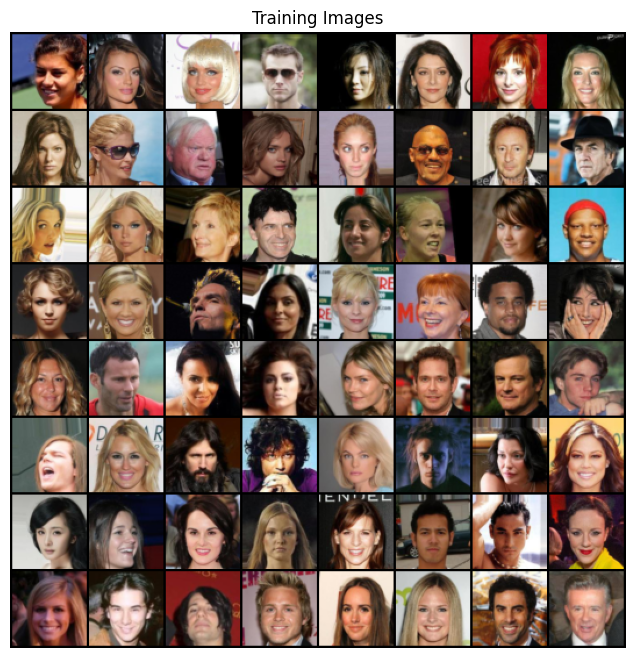

In [21]:
#show example training images
from matplotlib import pyplot as plt

real_batch = next(iter(train_data))
print(real_batch[0].shape)
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(torchvision.utils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

The architecture defined below is the first half of the GAN. The Discriminator is a convolutional neural network that aims to distinguish between real and generated images. It consists of four convolutional blocks, each followed by a Leaky ReLU activation function, and a final convolutional layer with a sigmoid activation function to output the probability of the input image being real. The architecure is adapted from the research papaer linked here: https://arxiv.org/abs/1511.06434 
![](GAN_architecture.png)

In [22]:
import torch.nn as nn
class Discriminator(nn.Module):
    
    def __init__(self, hidden_nodes=16, image_channel=1):
        super().__init__()
        self.layers=nn.Sequential(
             #block1
            nn.Conv2d(image_channel, hidden_nodes, 4, 2, 1, bias=True),
            nn.LeakyReLU(0.2, inplace=True),
            #block 2
            nn.Conv2d(hidden_nodes, hidden_nodes*2, 4, 2, 1, bias=True),
            nn.BatchNorm2d(hidden_nodes*2),
            nn.LeakyReLU(0.2, inplace=True),
            #block 3
            nn.Conv2d(hidden_nodes*2, hidden_nodes*4, 4, 2, 1, bias=True),
            nn.BatchNorm2d(hidden_nodes*4),
            nn.LeakyReLU(0.2, inplace=True),

            #block 4
            nn.Conv2d(hidden_nodes * 4, hidden_nodes * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(hidden_nodes * 8),
            nn.LeakyReLU(0.2, inplace=True),

            #final layer
            nn.Conv2d(hidden_nodes*8, 1, 4, 1, 0),
            nn.Sigmoid(),
           
        )
    
    def forward(self, x: torch.Tensor):
        x=self.layers(x)
        return x.view(-1)

discriminator=Discriminator(64, 3)


Below the generator part of the GAN is defined. The Generator is a deconvolutional neural network that generates images from random noise. It consists of four deconvolutional blocks, each followed by a BatchNorm and ReLU activation function, and a final deconvolutional layer with a Tanh activation function to produce the output image. This architecture is based on the research paper and diagram above.

In [24]:
class Generator(nn.Module):
    def __init__(self,z_dim=10, hidden_nodes=64, image_channel=1):
        super(Generator, self).__init__() 
        self.z_dim=z_dim
        self.layers=nn.Sequential(
            #block1
            nn.ConvTranspose2d(z_dim, hidden_nodes*8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(hidden_nodes*8),
            nn.ReLU(inplace=True),
            #block 2
            nn.ConvTranspose2d(hidden_nodes*8, hidden_nodes*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(hidden_nodes*4),
            nn.ReLU(inplace=True),
            #block 3
            nn.ConvTranspose2d(hidden_nodes*4, hidden_nodes*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(hidden_nodes*2),
            nn.ReLU(inplace=True),

            #block 4
            nn.ConvTranspose2d(hidden_nodes*2, hidden_nodes, 4, 2, 1, bias=False),
            nn.BatchNorm2d(hidden_nodes),
            nn.ReLU(inplace=True),

            #final layer
            nn.ConvTranspose2d(hidden_nodes, image_channel, 4, 2, 1, bias=False),
            nn.Tanh()
        )
    
    # forward method
    def forward(self, x): 
        x = x.view(len(x), self.z_dim, 1, 1)
        return self.layers(x)

generator=Generator(100, 64, 3)
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
generator.apply(weights_init)
discriminator.apply(weights_init)

Discriminator(
  (layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1))
    (12): Sigmoid()
  )
)

Below two functions are defined, gen_train_step and train_step, which train the Generative Adversarial Network (GAN) which consists of a generator and discriminator. The gen_train_step function updates the generator's parameters by minimizing its loss using the discriminator's output. The train_step function trains both the generator and discriminator in an alternating fashion by looping through the data loader's batches. It computes the real loss, fake loss, and total loss for the discriminator, and updates the discriminator's and generator's parameters using their respective optimizers. The two networks are essentially pitted against each other where the discriminator tries to determine fake images from real images and the generator tries to trick the discriminator.

In [23]:
def gen_train_step(generator:  torch.nn.Module,
                   discriminator: torch.nn.Module,
               criterion: torch.nn.Module, 
               gen_optimizer: torch.optim.Optimizer):
        
        
        gen_optimizer.zero_grad()

        z = torch.randn(128, 100, device=device)
        y = torch.ones(128, device=device)

        gen_output = generator(z)
        disc_output = discriminator(gen_output)
        gen_loss = criterion(disc_output, y)

        # gradient backprop & optimize ONLY gen parameters
        gen_loss.backward()
        gen_optimizer.step()
        return gen_loss.data.item()


def train_step(discriminator: torch.nn.Module,
               generator:  torch.nn.Module,
               dataloader: torch.utils.data.DataLoader, 
               criterion: torch.nn.Module, 
               disc_optimizer: torch.optim.Optimizer,
               gen_optimizer: torch.optim.Optimizer):
    # Put model in train mode
    discriminator.train()
    generator.train()
    
    # Setup train loss and train accuracy values
    gen_train_loss, disc_train_loss = 0, 0
    
    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        X=X.to(device)
        
        disc_optimizer.zero_grad()
        
        # calc real loss
        y_pred = discriminator(X)

        
        label = torch.ones(X.size(0), device=device)
        real_loss = criterion(y_pred, label)
        real_loss.backward(retain_graph=True)

        
        
        # calc fake loss
        z = torch.randn(X.size(0), 100, device=device)
        fake_output=generator(z)
       
        fake_pred=discriminator(fake_output)
        label.fill_(0)
        fake_loss=criterion(fake_pred, label)

        fake_loss.backward(retain_graph=True)
        
        total_loss_d=fake_loss+real_loss
        

    



        
        

        # Optimizer step for disc
        disc_optimizer.step()
        
        #train the generator now
        gen_optimizer.zero_grad()

        fake_pred=discriminator(fake_output)
        label.fill_(1)
        gen_loss=criterion(fake_pred, label)
        gen_loss.backward()
        gen_optimizer.step()
        
        disc_train_loss+=real_loss.item()+fake_loss.item()
        gen_train_loss+=gen_loss.item()
        
       

    # Adjust metrics to get average loss and accuracy per batch 
    gen_train_loss = gen_train_loss / len(dataloader)
    disc_train_loss = disc_train_loss / len(dataloader)
    return gen_train_loss, disc_train_loss

In [25]:
from tqdm.auto import tqdm

def train(discriminator: torch.nn.Module,
          generator:  torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,  
          epochs: int = 5):
    discriminator=discriminator.to(device)
    generator=generator.to(device)

    #set up loss and optimizers
    loss_fn = nn.BCELoss()
    beta_1 = 0.5         
    beta_2 = 0.999
    disc_optimizer = torch.optim.Adam(params=discriminator.parameters(), lr=0.0002, betas=(beta_1, beta_2))
    gen_optimizer=torch.optim.Adam(params=generator.parameters(), lr=0.0002, betas=(beta_1, beta_2))
    
    # Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": [],
        "sample_images":[]
    }
    
    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        disc_train_loss, gen_train_loss = train_step(discriminator=discriminator,
                                           generator=generator,
                                           dataloader=train_dataloader,
                                           criterion=loss_fn,
                                           disc_optimizer=disc_optimizer,
                                           gen_optimizer=gen_optimizer)
        
        
        # Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"disc_train_loss: {disc_train_loss:.4f} | "
            f"gen_train_loss: {gen_train_loss:.4f} | "
        )

        # Update results dictionary
        results["disc_train_loss"].append(disc_train_loss)
        results["gen_train_loss"].append(gen_train_loss)
        
        if epoch%1==0:
            #for each epoch generate random samples
            tempz = torch.randn(25, 100, device=device)
            generator.eval()
            indexTemp=0
            sample_image=generator(tempz)
            for generated in sample_image:
                indexTemp+=1
                save_image((generated+1)/2, './images_celeb_conv_gan/sample_'+str(20+epoch)+'_e_'+str(indexTemp) + '.png')

       

    # Return the filled results at the end of the epochs
    discriminator=discriminator.to('cpu')
    generator=generator.to('cpu')
    return results

In [26]:

# Set number of epochs
NUM_EPOCHS = 20





# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Train model 
model_results = train(discriminator=discriminator,
                        generator=generator, 
                        train_dataloader=train_data,
                        epochs=NUM_EPOCHS)
torch.save(discriminator.state_dict(), './models_celeb_conv/d_10')
torch.save(generator.state_dict(), './models_celeb_conv/g_10')
# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | disc_train_loss: 4.5833 | gen_train_loss: 0.8047 | 
Epoch: 2 | disc_train_loss: 3.0920 | gen_train_loss: 0.7379 | 
Epoch: 3 | disc_train_loss: 2.5752 | gen_train_loss: 0.8050 | 
Epoch: 4 | disc_train_loss: 2.4249 | gen_train_loss: 0.8081 | 
Epoch: 5 | disc_train_loss: 2.4110 | gen_train_loss: 0.7933 | 
Epoch: 6 | disc_train_loss: 2.4992 | gen_train_loss: 0.7506 | 
Epoch: 7 | disc_train_loss: 2.6383 | gen_train_loss: 0.6749 | 
Epoch: 8 | disc_train_loss: 2.8289 | gen_train_loss: 0.6280 | 
Epoch: 9 | disc_train_loss: 3.0785 | gen_train_loss: 0.5319 | 
Epoch: 10 | disc_train_loss: 3.3110 | gen_train_loss: 0.4894 | 
Epoch: 11 | disc_train_loss: 3.5076 | gen_train_loss: 0.4907 | 
Epoch: 12 | disc_train_loss: 3.7063 | gen_train_loss: 0.3939 | 
Epoch: 13 | disc_train_loss: 3.9950 | gen_train_loss: 0.3507 | 
Epoch: 14 | disc_train_loss: 4.0196 | gen_train_loss: 0.3577 | 
Epoch: 15 | disc_train_loss: 4.0676 | gen_train_loss: 0.3841 | 
Epoch: 16 | disc_train_loss: 4.2395 | gen_train_l

In [27]:
#generate random samples from noise
z = torch.randn(25, 100)
generator=generator.to('cpu')
sample_images = generator(z)


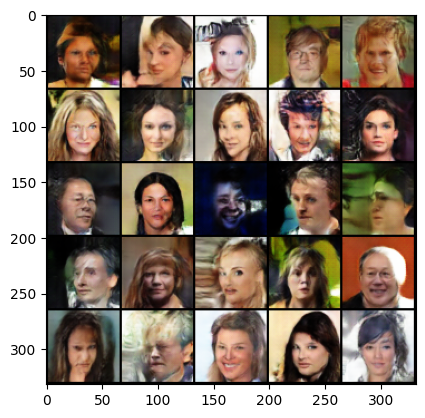

In [45]:
#show and save samples
index=0
for generated in sample_images:
    index+=1
    save_image((generated+1)/2, './samples_celeb_conv_gan/sample_'+str(index) + '.png')

from torchvision.utils import make_grid
from matplotlib import pyplot as plt
def show_tensor_images(tensor_img, num_img=25, size=(3, 64, 64)):
    tensor_img = (tensor_img + 1) / 2
    unflat_img = tensor_img.detach().cpu()
    img_grid = make_grid(unflat_img[:num_img], nrow=5)
    plt.imshow(img_grid.permute(1, 2, 0).squeeze())
    plt.show()


show_tensor_images(sample_images)

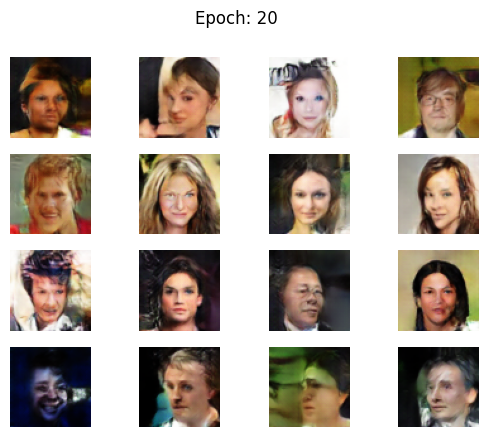

In [47]:
from matplotlib import pyplot
import matplotlib.image as mpimg
import imageio
def save_plot(examples, n,index, filenames):
    
    
    for i in range(n * n):
        pyplot.subplot(n, n, 1 + i)
        pyplot.axis('off')
        pyplot.imshow(examples[i])
        
    #pyplot.show()
    pyplot.suptitle("Epoch: "+str(index))

    pyplot.savefig('./samples_celeb_conv_gan/gan_mnst_graph_'+str(index)+".png")
    filenames.append('./samples_celeb_conv_gan/gan_mnst_graph_'+str(index)+".png")

index=0
filenames=[]

#make plots for each epoch

for epoch in range(NUM_EPOCHS):
    images = []
    for ind in range(20):
        images.append( mpimg.imread('./images_celeb_conv_gan/sample_'+str(epoch)+'_e_'+str(ind+1) + '.png'))
    
    save_plot(images,4, epoch,filenames)
images=[]
for ind in range(20):
    images.append( mpimg.imread('./samples_celeb_conv_gan/sample_'+str(ind+1) + '.png'))
save_plot(images,4, NUM_EPOCHS,filenames)

In [44]:
#make GIF of results
import imageio
images = []

for filename in filenames:
    images.append(imageio.imread(filename))
imageio.mimsave('./movieConv.gif', images,duration=0.5)

<ipython-input-44-e05b001e21e2>:5: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(filename))


In [31]:
print(discriminator)

Discriminator(
  (layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1))
    (12): Sigmoid()
  )
)


In [32]:
print(generator)

Generator(
  (layers): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )


In [33]:
#zip everything
import os
import zipfile

zf = zipfile.ZipFile("./files.zip", "w")
zf.write("./movieConv.gif")
for dirname, subdirs, files in os.walk("./models_celeb_conv"):
    zf.write(dirname)
    for filename in files:
        zf.write(os.path.join(dirname, filename))
for dirname, subdirs, files in os.walk("./images_celeb_conv_gan"):
    zf.write(dirname)
    for filename in files:
        zf.write(os.path.join(dirname, filename))
for dirname, subdirs, files in os.walk("./samples_celeb_conv_gan"):
    zf.write(dirname)
    for filename in files:
        zf.write(os.path.join(dirname, filename))
zf.close()

In [34]:
#download stuff
from google.colab import files
files.download("./files.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>